# GRAPH PLOTTER SCRIPT  

This script highlights some correlations present between the parameters chosen to conduce the simulations and the execution time that is required to complete them.

In particular have been conduced 4 main types of experiments: 
- Increasing number of data 
- Increasing number of workers
- Increasing failure probability
- Increasing batch size  

All the experiments were conduced keeping constant the schedule and its parameters, which are: 

schedule : {"gt", "changekey", "mul", "changekey", "changekey", "div", "le", "add", "changekey", "sub", "div", "reduce"}  
parameters : {15, 0, 4, 0, 0, 5, 84, 25, 0, 4, 3, 0}
    

In [1]:
import matplotlib.pyplot as plt
import os

In [2]:
#Initialization of some variables that are usefull in the whole project
parameter = "number_of_data"

number_of_workers = 0
number_of_data = 0
failure_probability = 0
batch_size = 0
schedule_size = 0

sim_data = []

In [3]:
#Function that reads the data from one log file of one experiment and stores it in a list
 
def read_log_to_vector(file_path):
    vector = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                number = float(line.strip())  
                vector.append(number)
            except ValueError:
                print(f"Skipping non-numeric value: {line.strip()}")
    return vector

#Function that iterates over all the logs of one experiment storing the data, the filename and the type of file in a list of tuples

def read_logs_from_directory(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".log"):
            file_path = os.path.join(directory_path, filename)
            vector = read_log_to_vector(file_path)
            file_type = filename.split('_')[0]
            data.append((file_type, filename, vector))  
    return data

In [4]:

#Funcion that at first uses the list of tuples previously created to seprarate the data of the entire simulation from the data of 
#the workers and retrieves the usefull variables from the name of the simulation file. 
#Then it creates a list of lists where each list is assigned to a worker and contains all its data of one experiment.
#The data of each worker is stored in a tuple that contains the id of the worker, the value of the parameter that is being varied in 
#the experiment, the sum of the map results, the sum of the filter results, the sum of the changekey results, the sum of the reduce
#results and the total simulation time of each experiment.


def creating_worker_data(directory_path):
    global number_of_workers
    global number_of_data
    global failure_probability
    global batch_size
    global schedule_size
    wrk_data = []

    all_data = read_logs_from_directory(directory_path)
    
    for idx, (file_type, filename, vector) in enumerate(all_data, start=1):
        if file_type == "SIM":
            sim_data_vector = vector[0]
            simulation_name = filename
        elif file_type == "WRK":
            wrk_data.append((filename, vector))
            
    sim_parts = simulation_name.split('_')
    number_of_workers = int(sim_parts[1])
    failure_probability = float(sim_parts[2])
    number_of_data = int(sim_parts[3])
    batch_size = int(sim_parts[4])
    schedule_size = int(sim_parts[5].split('.')[0])
    
    if parameter == "number_of_workers":
        par = int(number_of_workers)
    elif parameter == "number_of_data":
        par = number_of_data
    elif parameter == "failure_probability":
        par = failure_probability
    elif parameter == "batch_size":
        par = batch_size
    elif parameter == "schedule_size":
        par = schedule_size

    map_results = []
    filter_results = []
    changekey_results = []
    reduce_results = []
    exec_time = []

    sim_data.append((par, sim_data_vector))

    for id, (filename, vector) in enumerate(wrk_data, start=1):
        wrk_parts = filename.split('_')
        if wrk_parts[2] == "map":
            map_results.append(sum(vector))
        elif wrk_parts[2] == "filter":
            filter_results.append(sum(vector))
        elif wrk_parts[2] == "changekey":
            changekey_results.append(sum(vector))
        elif wrk_parts[2] == "execTime":
            exec_time.append(sum(vector))
        elif wrk_parts[2] == "reduce":
            reduce_results.append(sum(vector))

    operation_dataset = [[] for _ in range(number_of_workers)]
    
    for idx in range(number_of_workers):
        wrk_istance = ((idx, par, map_results[idx], filter_results[idx], changekey_results[idx], reduce_results[idx]))
        operation_dataset[idx].append(wrk_istance)

    return operation_dataset
 
    

In [5]:
#Function that iterates over all the subdirectories of each experiment for then retrieving all the logs of each simulations.
#It expects as input the path of the directory where all teh simulations are stored. 

wrk_dataset = []

def iterate_subdirectories(directory_path):
    global wrk_dataset 
    global sim_data
    wrk_dataset = []
    sim_data = []
    first_iteration = True

    for subdirectory in os.listdir(directory_path):
        subdirectory_path = os.path.join(directory_path, subdirectory)
        
        if os.path.isdir(subdirectory_path):
            appo = creating_worker_data(subdirectory_path)
            if first_iteration:
                wrk_dataset = appo
                first_iteration = False
            else:
                current_number_of_workers = len(wrk_dataset)
                if number_of_workers > current_number_of_workers:
                    wrk_dataset.extend([[] for _ in range(number_of_workers - current_number_of_workers)])
                for idx in range(number_of_workers):
                    wrk_dataset[idx].extend(appo[idx])


In [10]:
#This function is used to plot the data of the simulations. It expects as input the parameter that is being varied in the experiments,
#the data of the parameter, the data of the map operation, the data of the filter operation, the data of the changekey operation, the
#data of the reduce operation and the data of the total execution time of the simulation.
#It differentiates the plots based on the parameter that is being varied in the experiments.
#In the case of the total_execution_time it plots only one graph, in the other cases it plots 4 graphs one for each worker, this because 
#the total simulation time is the same for all the workers, while the time of the operations is different for each worker.

def plotter(parameter_vector, map_vector, filter_vector, changekey_vector, reduce_vector, sim_data):
    
    if parameter != "batch_size":
        fig, axs = plt.subplots(5, 1, figsize=(10, 20))
    else:
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        
    operations = ['Map', 'Filter', 'ChangeKey', 'Reduce', 'Total_Execution_Time']

    # Plot each operation
    if parameter != "batch_size":
        for i, operation in enumerate(operations):
            # Plot data for each worker
            for j in range(number_of_workers):
                if operation == 'Map':
                    if parameter == "number_of_workers":
                        axs[i].plot(parameter_vector[j], map_vector[j])
                    else:
                        axs[i].plot(parameter_vector[j], map_vector[j], label=f"Worker {j}")
                elif operation == 'Filter':
                    if parameter == "number_of_workers":
                        axs[i].plot(parameter_vector[j], filter_vector[j], label ="_nolegend_")
                    else:
                        axs[i].plot(parameter_vector[j], filter_vector[j], label=f"Worker {j}")
                elif operation == 'ChangeKey':
                    if parameter == "number_of_workers":
                        axs[i].plot(parameter_vector[j], changekey_vector[j])
                    else:
                        axs[i].plot(parameter_vector[j], changekey_vector[j], label=f"Worker {j}")
                elif operation == 'Reduce':
                    if parameter == "number_of_workers":
                        axs[i].plot(parameter_vector[j], reduce_vector[j])
                    else:
                        axs[i].plot(parameter_vector[j], reduce_vector[j], label=f"Worker {j}")
            if operation == 'Total_Execution_Time':
                axs[i].plot(parameter_vector[0], sim_data)
    
            # Set titles and labels
            if(i == 4):
                axs[i].set_title("Total Execution Time")
            else:
                axs[i].set_title(f"{operation} Operation")
            axs[i].set_xlabel(parameter)
            axs[i].set_ylabel(f"{operation} Time")
            if(i != 4 and parameter != "number_of_workers"):
                axs[i].legend()
    else:
        axs.plot(parameter_vector[0], sim_data)
        axs.set_title("Total Execution Time")
        axs.set_xlabel(parameter)   
        axs.set_ylabel("Time")
    plt.tight_layout()
    plt.show()


In [11]:
#Function that is used to split the data of the logs of the workers in the different operations and then call the plotter function
#after that the data is sorted based on the parameter that is being varied in the experiments.

def splitting_logs():
    parameter_vector = [[] for _ in range(number_of_workers)]
    map_vector = [[] for _ in range(number_of_workers)]
    filter_vector = [[] for _ in range(number_of_workers)]
    changekey_vector = [[] for _ in range(number_of_workers)]
    reduce_vector = [[] for _ in range(number_of_workers)]
    
    sorted_data = [sorted(inner_list, key=lambda x: x[1]) for inner_list in wrk_dataset]

    for idx, wrk in enumerate(sorted_data):
        for log in wrk:
            parameter_vector[idx].append(log[1])
            map_vector[idx].append(log[2])
            filter_vector[idx].append(log[3])
            changekey_vector[idx].append(log[4])
            reduce_vector[idx].append(log[5])

    sim_data_sorted = sorted(sim_data, key=lambda x: x[0])
    sim_data_sorted = [x[1] for x in sim_data_sorted]
    
    plotter(parameter_vector, map_vector, filter_vector, changekey_vector, reduce_vector, sim_data_sorted)

## INCREASING NUMBER OF DATA 

- The data size is increased at every simulation of 500 + (0:10) values and is divided among all the workers
- The number of workers is fixed at 4 
- The failure probability is fixed at 0.1
- The batch size is fixed at 8

Considerations:  

As expected the workload of each worker increases with the data quantity

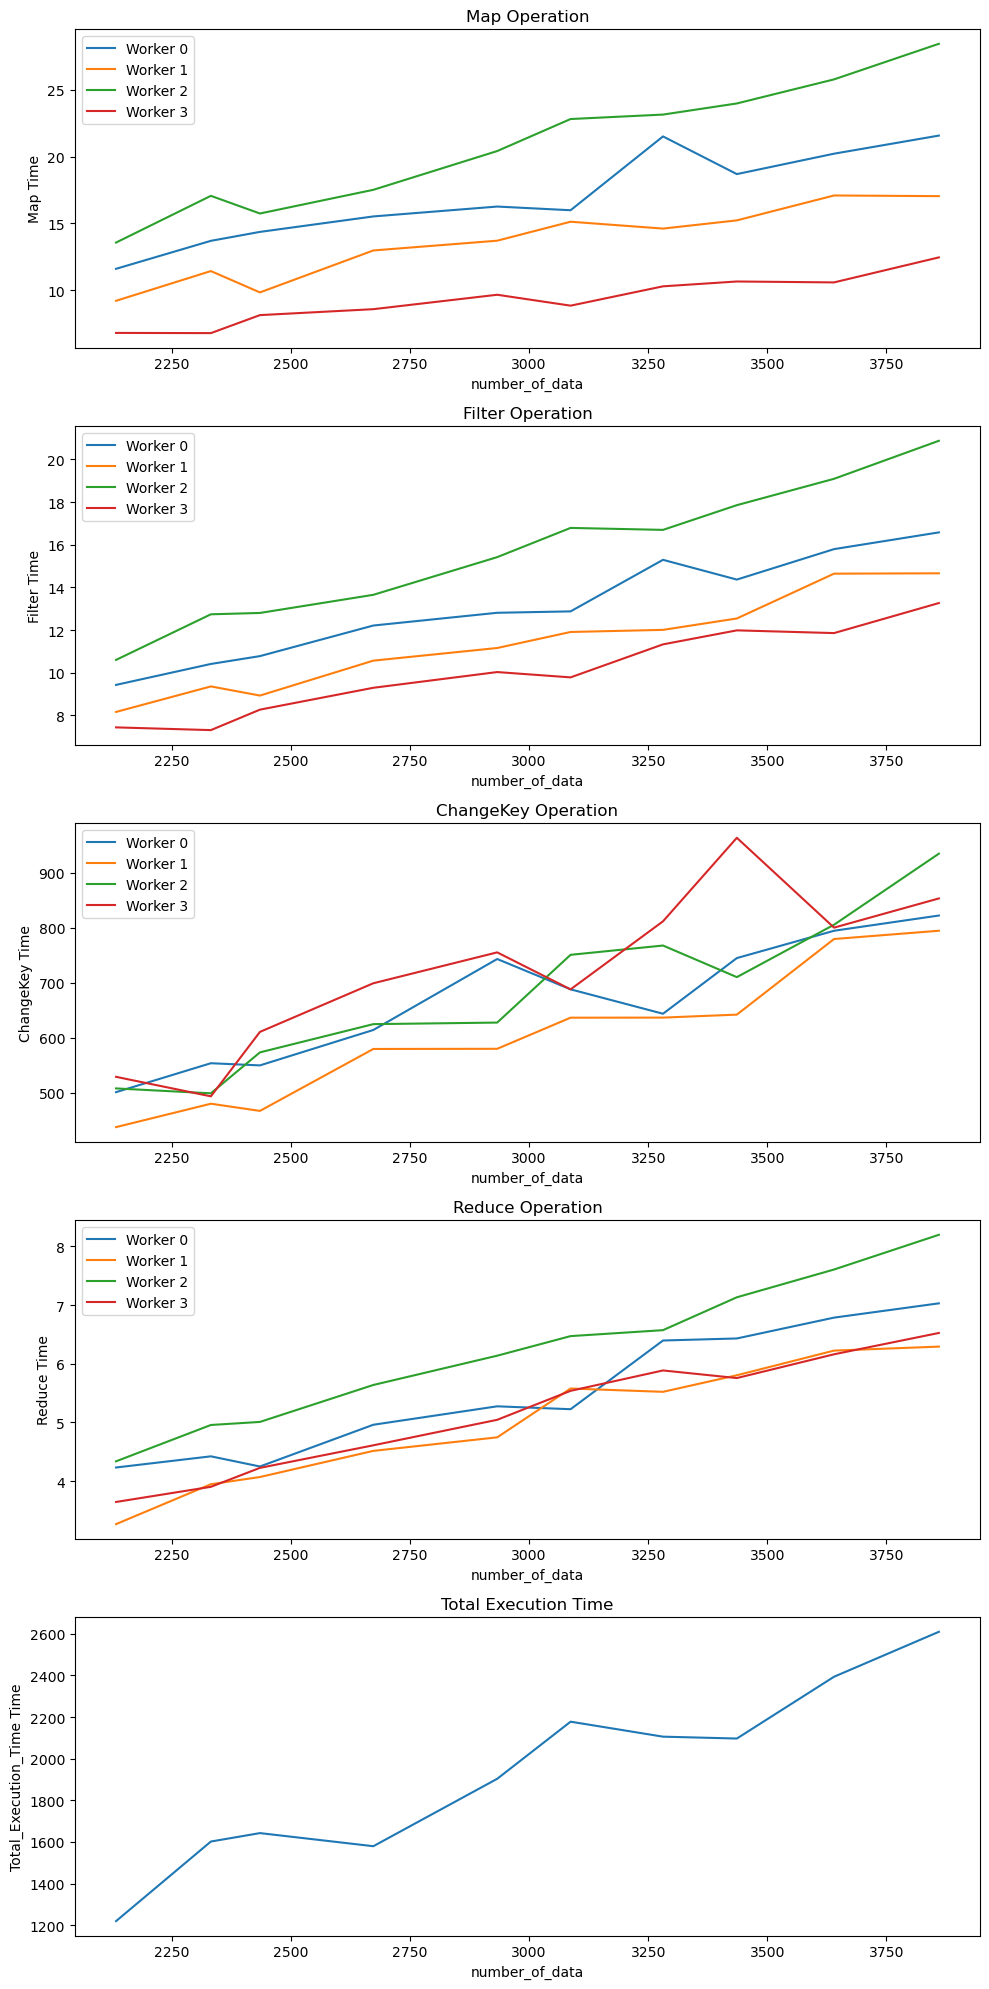

In [12]:
parameter = "number_of_data"
iterate_subdirectories("Logs/Increasing_Number_of_Data")
splitting_logs()

# INCREASING NUMBER OF WORKERS

- The number of workers is increased at each simulation, in particular have been used 1, 2, 3, 4, 5, 6, 8, 10, 15, 30 workers
- The quantity of data is always 5000 + (0:50), is then divided among all the workers available in each simulation
- The failure probability is fixed at 0.1
- The batch size is fixed at 8

Conisderations:  

Every line in the graph represents the workload of each worker. The lines are introduced in the middle of the graphs and not at the beginning because whenever a new simulation is performed new workers are added and so the plotting regarding them starts from that point.  

It can be seen that each time new workers are inserted, the individual workload decreases, and the more workers are added, the less total workload there will be for each of them.

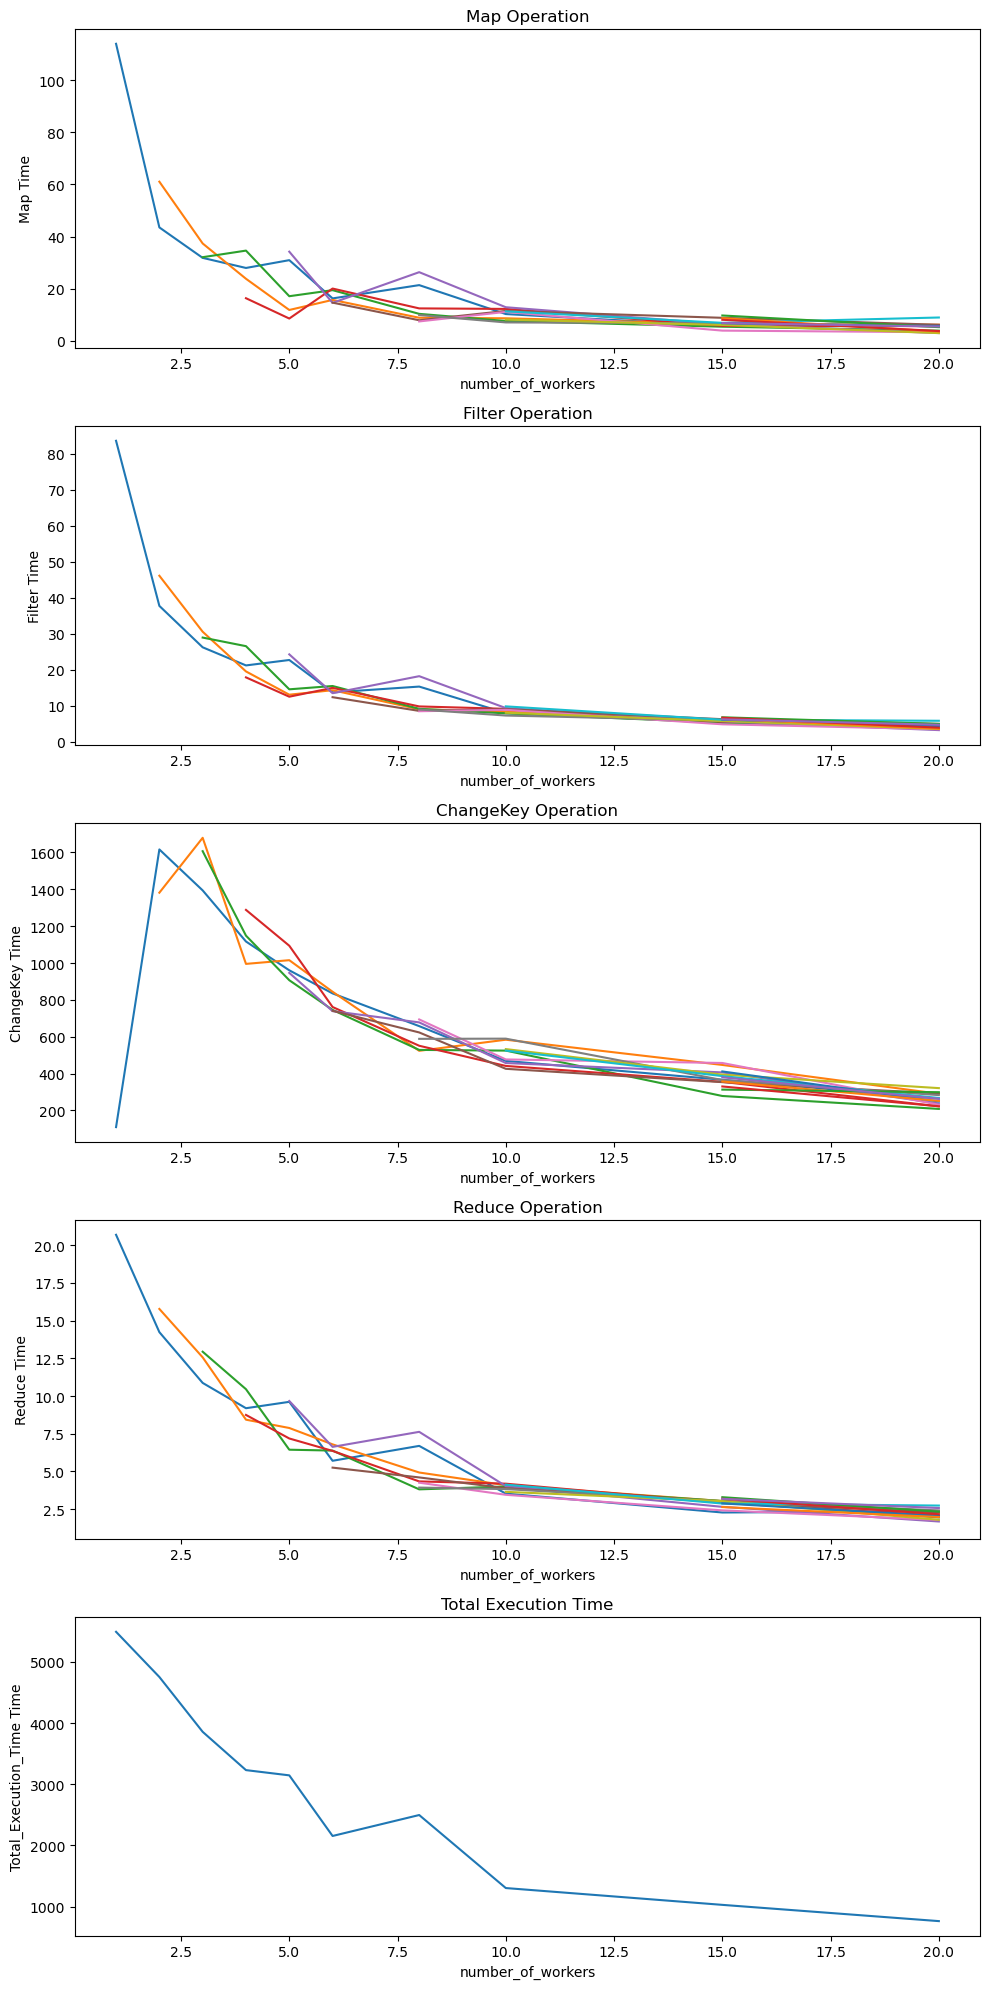

In [13]:
parameter = "number_of_workers"
iterate_subdirectories("Logs/Increasing_Number_of_Workers")
splitting_logs()

# INCREASING FAILURE PROBABILITY 

- The failure probability is increased at each simulation, in particular have been used 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0      probabilities of crashing for each operation that is executed by each worker
- The quantity of data is always 1250 + (0:25) for each worker
- The number of workers is kept constant at 4
- The batch size is fixed at 8

Considerations:  

As expected each operation executed by each worker is influenced by the probability of failing, in particular more the failing probability more is the workload of each worker, which leeds to an higher execution time.

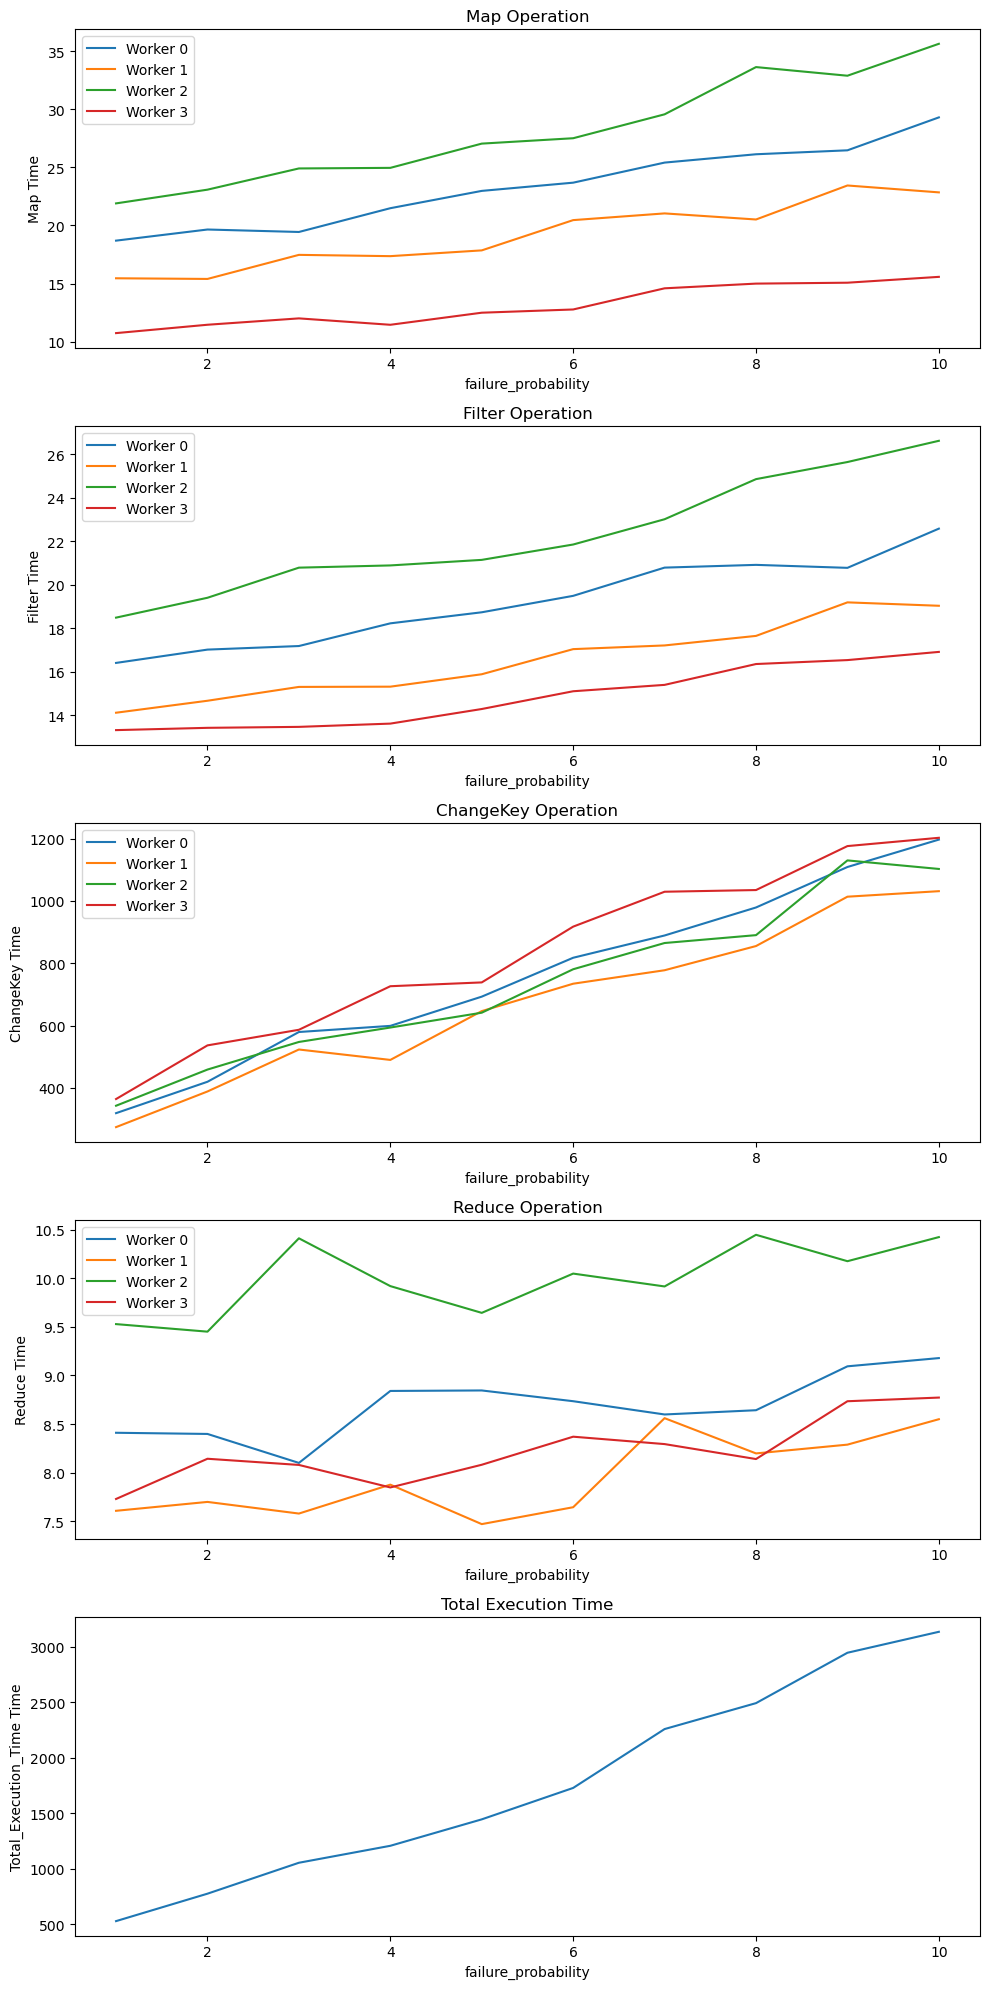

In [14]:
parameter = "failure_probability"
iterate_subdirectories("Logs/Increasing_Failure_Probability")
splitting_logs()

# INCREASING BATCH SIZE 
- The batch size is chosen selecting various values between 1 and 120 
- The number of data is kept constant at 1250 + (0:25)
- The number of workers is fixed at 4
- The failure probability is fixed at 0.1

Considerations:
  
Is clearly visible from the graph that continusly increasing the batch size is proficous only until certain values. This is correct since the more the batch is increased, the higher the probability of failing inside of it, and since the worker restarts from the beginning of the batch when it is activated again, this leeds to an increase of total simulation time. 

Fixing the failure probability, the schedule size, the total amount of data and the number of workers makes it possible to find the optimal batch size for a specific set of parameters.  
This must be done in parallel with the fine tuning of all the worker's delay constants, using the most appropriate values to simulate a real scenario. 

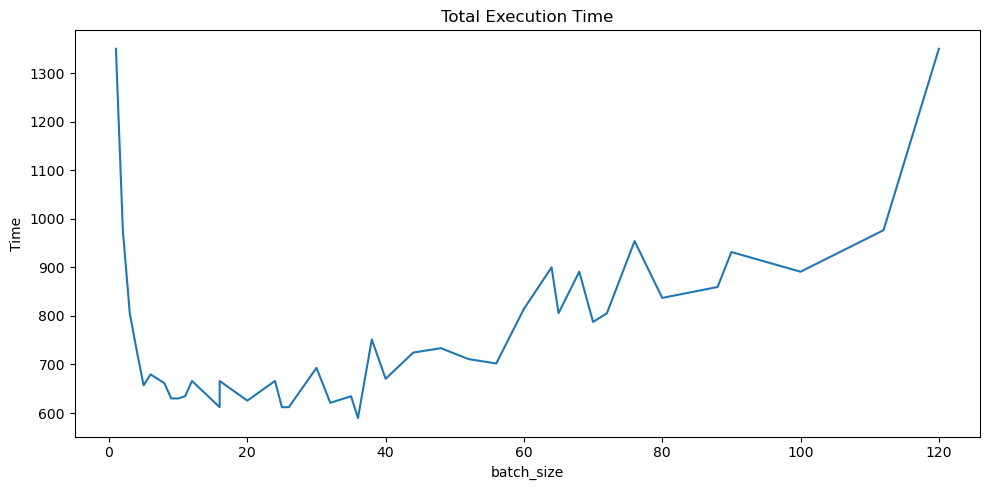

In [15]:
parameter = "batch_size"
iterate_subdirectories("Logs/Increasing_Batch_Size_Failure_Probability_High")
splitting_logs()